In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets

import helper
import numpy as np

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training data
train_set = datasets.ImageFolder('out/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Load the test data
test_set = datasets.ImageFolder('out/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

# Load the validation data
validation_set = datasets.ImageFolder('out/validation/', transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

In [5]:
# Create model
model = nn.Sequential(nn.Linear(784, 256),
                     nn.ReLU(),
                     nn.Linear(256, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64, 10),
                     nn.Dropout(p=0.2),
                     nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.03)

In [6]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten images
        images = images.view(images.shape[0], -1)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        # Forwards pass, then backward pass, then update weights
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            for images, labels in test_loader:
                # Flatten images
                images = images.view(images.shape[0], -1)
                
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        # Set model to train mode
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Training Loss: 2.273..  Test Loss: 2.213..  Test Accuracy: 0.306
Epoch: 2/30..  Training Loss: 2.068..  Test Loss: 1.902..  Test Accuracy: 0.332
Epoch: 3/30..  Training Loss: 1.856..  Test Loss: 1.723..  Test Accuracy: 0.388
Epoch: 4/30..  Training Loss: 1.777..  Test Loss: 1.673..  Test Accuracy: 0.431
Epoch: 5/30..  Training Loss: 1.709..  Test Loss: 1.582..  Test Accuracy: 0.473
Epoch: 6/30..  Training Loss: 1.661..  Test Loss: 1.554..  Test Accuracy: 0.480
Epoch: 7/30..  Training Loss: 1.615..  Test Loss: 1.543..  Test Accuracy: 0.482
Epoch: 8/30..  Training Loss: 1.583..  Test Loss: 1.530..  Test Accuracy: 0.474
Epoch: 9/30..  Training Loss: 1.551..  Test Loss: 1.468..  Test Accuracy: 0.522
Epoch: 10/30..  Training Loss: 1.515..  Test Loss: 1.424..  Test Accuracy: 0.535
Epoch: 11/30..  Training Loss: 1.491..  Test Loss: 1.440..  Test Accuracy: 0.518
Epoch: 12/30..  Training Loss: 1.450..  Test Loss: 1.483..  Test Accuracy: 0.493
Epoch: 13/30..  Training Loss: 1.420.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

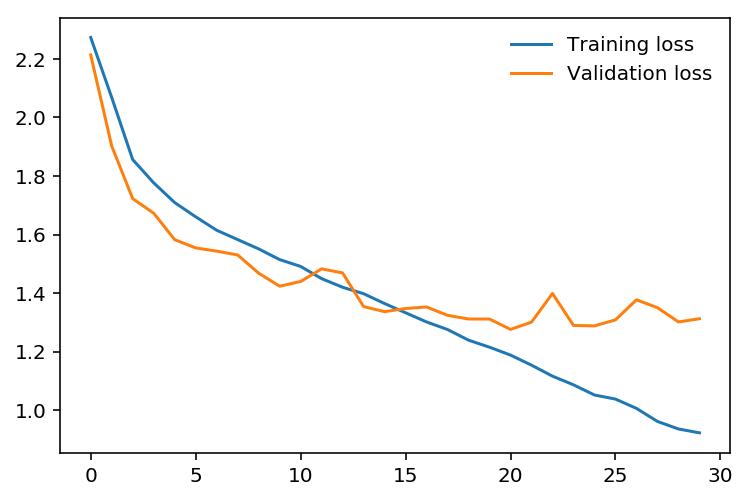

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

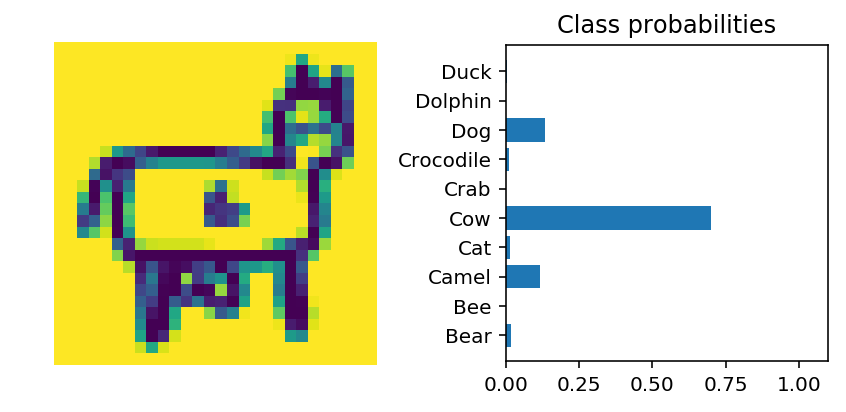

In [12]:
model.eval()

validator_inter = iter(validation_loader)
images, labels = validator_inter.next()
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classification_result(img.view(1, 28, 28), ps)